<a href="https://colab.research.google.com/github/LeeMinJun0102/Car_Price_Predict/blob/main/CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm
import ast

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import plot_tree, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from scipy.stats import randint, uniform, loguniform

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Final.xlsx to Final.xlsx


In [ ]:
df = pd.read_excel('Final.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8862 entries, 0 to 8861
Data columns (total 97 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   delete before                        8862 non-null   int64  
 1   sales_date                           8862 non-null   int64  
 2   branch                               8862 non-null   object 
 3   original_manager                     8862 non-null   object 
 4   salesperson_id                       8861 non-null   float64
 5   salesperson                          8861 non-null   object 
 6   manufacturer                         8862 non-null   object 
 7   model                                8862 non-null   object 
 8   category_major                       8862 non-null   object 
 9   category_minor                       4173 non-null   object 
 10  car_number                           8862 non-null   object 
 11  year                          

In [ ]:
df.head()

,delete before,sales_date,branch,original_manager,salesperson_id,salesperson,manufacturer,model,category_major,category_minor,...,year_num,month_num,usedyear,sales_channel_grouping,purchase_channel_1_grouping,fuel_grouping,transmission_grouping,manufacturer_grouping,color_grouping,car_type_grouping
0,0,20190131,수원지점,노영규,2025.0,노영규,기아,올 뉴 모닝,디럭스,NaN,...,2011,4,7.833333,온라인 고객,개인,가솔린,오토,기아,쥐색,경차
1,1,20190131,오산경매장,김승일,1463.0,김승일,기아,뉴모닝,LX 스페셜,NaN,...,2009,10,9.333333,경매,영업소,가솔린,수동,기아,쥐색,경차
2,2,20190131,오산경매장,피정민,1822.0,피정민,기아,뉴모닝,LX,기본형,...,2010,12,8.166667,경매,개인,가솔린,오토,기아,은색,경차
3,4,20190131,오산경매장,박민수,2282.0,박민수,기아,New 스포티지,디젤(VGT) 2WD TLX,최고급형,...,2009,6,9.666667,경매,영업소,디젤,오토,기아,은색,SUV
4,5,20190131,오산경매장,박근수,1585.0,박근수,기아,올 뉴 모닝,디럭스 스페셜,NaN,...,2011,12,7.166667,경매,영업소,가솔린,오토,기아,쥐색,경차


# X / y

In [ ]:
X = df[['manufacturer_grouping',
        'car_type_grouping',
        'mileage',
        'color_grouping',
        'fuel_grouping',
        'transmission_grouping',
        'purchase_accident',
        'sales_channel_grouping',
        'purchase_channel_1_grouping',
        'new_car_price',
        'usedyear'
       ]]

y = df['residual_value_rate']
X.head()

,manufacturer_grouping,car_type_grouping,mileage,color_grouping,fuel_grouping,transmission_grouping,purchase_accident,sales_channel_grouping,purchase_channel_1_grouping,new_car_price,usedyear
0,기아,경차,107663,쥐색,가솔린,오토,무사고,온라인 고객,개인,10500000,7.833333
1,기아,경차,124694,쥐색,가솔린,수동,무사고,경매,영업소,9180000,9.333333
2,기아,경차,115812,은색,가솔린,오토,단순교환,경매,개인,8490000,8.166667
3,기아,SUV,140606,은색,디젤,오토,단순교환,경매,영업소,18250000,9.666667
4,기아,경차,144943,쥐색,가솔린,오토,무사고,경매,영업소,10630000,7.166667


# train / test 분할

In [ ]:
# train/test 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6203, 11), (2659, 11), (6203,), (2659,))

# CatBoostRegressor

## 전처리

In [ ]:
categorical_features = ['manufacturer_grouping', 'car_type_grouping', 'color_grouping',
                        'fuel_grouping', 'transmission_grouping', 'purchase_accident',
                        'sales_channel_grouping', 'purchase_channel_1_grouping']

X_train_cat = X_train.copy()
X_test_cat = X_test.copy()

for col in categorical_features:
    X_train_cat[col] = X_train_cat[col].astype(str)
    X_test_cat[col] = X_test_cat[col].astype(str)

cat_features_idx = [X_train_cat.columns.get_loc(col) for col in categorical_features]

## 모델 학습

In [ ]:
# catboost = CatBoostRegressor(
#     random_state=42,
#     verbose=0,
#     cat_features=cat_features_idx
# )

# # border_count 제거 (max_bin만 사용)
# param_distributions = {
#     'iterations': [500, 800, 1000, 1500, 2000],
#     'depth': [4, 5, 6, 7, 8, 9, 10],
#     'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1, 0.15],
#     'l2_leaf_reg': [1, 3, 5, 7, 9, 11, 15],
#     'random_strength': [0, 0.5, 1, 1.5, 2],

#     # max_bin만 사용 (border_count와 동일한 역할)
#     'max_bin': [32, 64, 128, 254, 512],

#     # bootstrap 관련 파라미터
#     'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
#     'bagging_temperature': [0, 0.3, 0.5, 0.7, 1.0],
#     'subsample': [0.7, 0.8, 0.85, 0.9, 0.95, 1.0],

#     # 추가 파라미터
#     'min_data_in_leaf': [1, 5, 10, 20, 30],
#     'one_hot_max_size': [2, 5, 10],
#     'rsm': [0.7, 0.8, 0.9, 1.0],
#     'leaf_estimation_iterations': [1, 5, 10]
# }

# random_search = RandomizedSearchCV(
#     estimator=catboost,
#     param_distributions=param_distributions,
#     n_iter=500,
#     cv=5,
#     scoring='neg_mean_squared_error',
#     n_jobs=-1,
#     random_state=42,
#     verbose=2
# )

# print("RandomizedSearchCV 실행 중...")
# random_search.fit(X_train_cat, y_train)

# best_model = random_search.best_estimator_
# print("\n최적 파라미터:")
# print(random_search.best_params_)

RandomizedSearchCV 실행 중...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits

최적 파라미터:
{'subsample': 0.95, 'rsm': 0.7, 'random_strength': 1.5, 'one_hot_max_size': 10, 'min_data_in_leaf': 30, 'max_bin': 254, 'learning_rate': 0.03, 'leaf_estimation_iterations': 5, 'l2_leaf_reg': 9, 'iterations': 1500, 'depth': 8, 'bootstrap_type': 'MVS', 'bagging_temperature': 0.7}


RandomizedSearchCV 실행 중...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits

최적 파라미터:
{'subsample': 0.95, 'rsm': 0.7, 'random_strength': 1.5, 'one_hot_max_size': 10, 'min_data_in_leaf': 30, 'max_bin': 254, 'learning_rate': 0.03, 'leaf_estimation_iterations': 5, 'l2_leaf_reg': 9, 'iterations': 1500, 'depth': 8, 'bootstrap_type': 'MVS', 'bagging_temperature': 0.7}

학습 과정 시각화를 위해 최적 모델 재학습 중...
R² 계산 중...


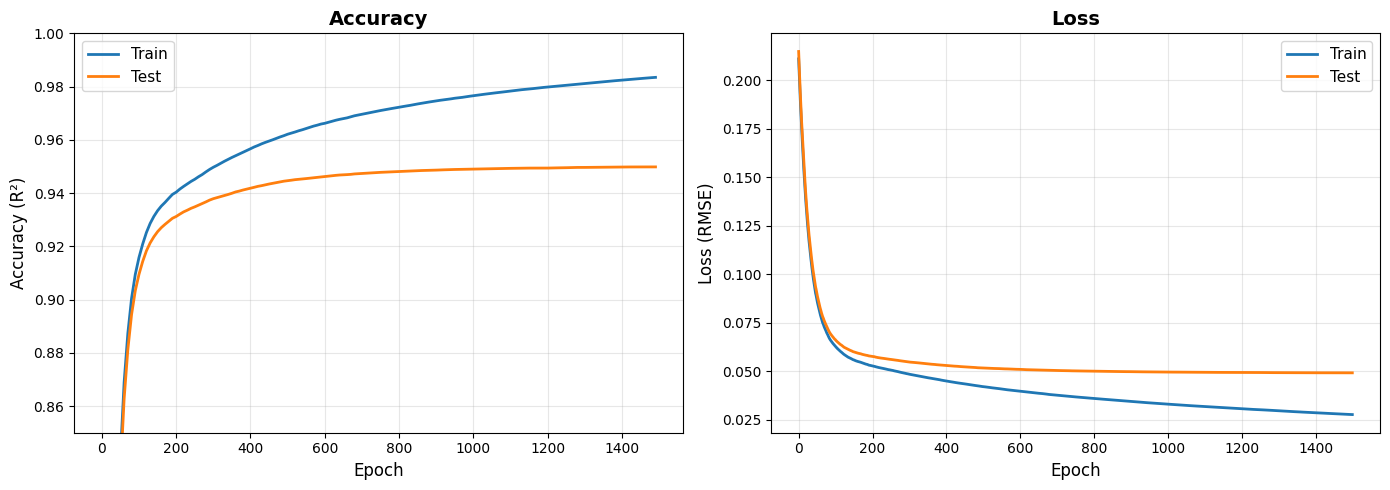


최종 모델 성능 평가

[Train Set]
  R²:    0.984 (98.4%)

[Test Set]
  R²:    0.950 (95.0%)


In [ ]:
# 1. RandomizedSearchCV로 최적 파라미터 찾기
catboost = CatBoostRegressor(
    random_state=42,
    verbose=0,
    cat_features=cat_features_idx
)

param_distributions = {
    'iterations': [500, 800, 1000, 1500, 2000],
    'depth': [4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1, 0.15],
    'l2_leaf_reg': [1, 3, 5, 7, 9, 11, 15],
    'random_strength': [0, 0.5, 1, 1.5, 2],
    'max_bin': [32, 64, 128, 254, 512],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
    'bagging_temperature': [0, 0.3, 0.5, 0.7, 1.0],
    'subsample': [0.7, 0.8, 0.85, 0.9, 0.95, 1.0],
    'min_data_in_leaf': [1, 5, 10, 20, 30],
    'one_hot_max_size': [2, 5, 10],
    'rsm': [0.7, 0.8, 0.9, 1.0],
    'leaf_estimation_iterations': [1, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=param_distributions,
    n_iter=500,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("RandomizedSearchCV 실행 중...")
random_search.fit(X_train_cat, y_train)

best_model = random_search.best_estimator_
print("\n최적 파라미터:")
print(random_search.best_params_)

# 2. 최적 모델로 다시 학습 (학습 과정 기록하면서)
print("\n학습 과정 시각화를 위해 최적 모델 재학습 중...")

final_model = CatBoostRegressor(
    **random_search.best_params_,
    random_state=42,
    cat_features=cat_features_idx,
    verbose=0
)

# eval_set으로 검증 데이터 전달
final_model.fit(
    X_train_cat, y_train,
    eval_set=(X_test_cat, y_test),
    verbose=False
)

# 3. 학습 기록 가져오기
train_loss = final_model.evals_result_['learn']['RMSE']
test_loss = final_model.evals_result_['validation']['RMSE']

# 4. R² 계산 (매 10 epoch마다만 계산 - 속도 향상)
epochs = range(0, len(train_loss), 10)  # 10 epoch마다
train_r2_history = []
test_r2_history = []

print("R² 계산 중...")
for i in epochs:
    y_train_pred = final_model.predict(X_train_cat, ntree_end=i+1)
    y_test_pred = final_model.predict(X_test_cat, ntree_end=i+1)

    train_r2_history.append(r2_score(y_train, y_train_pred))
    test_r2_history.append(r2_score(y_test, y_test_pred))

# 5. 그래프 그리기
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy (R²) 그래프
ax1.plot(list(epochs), train_r2_history, label='Train', color='#1f77b4', linewidth=2)
ax1.plot(list(epochs), test_r2_history, label='Test', color='#ff7f0e', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy (R²)', fontsize=12)
ax1.set_title('Accuracy', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0.85, 1.0])  # R² 범위 조정

# Loss (RMSE) 그래프
ax2.plot(train_loss, label='Train', color='#1f77b4', linewidth=2)
ax2.plot(test_loss, label='Test', color='#ff7f0e', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss (RMSE)', fontsize=12)
ax2.set_title('Loss', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. 최종 성능 평가
y_train_pred = final_model.predict(X_train_cat)
y_test_pred = final_model.predict(X_test_cat)

train_r2_final = r2_score(y_train, y_train_pred)
test_r2_final = r2_score(y_test, y_test_pred)

print("\n" + "="*50)
print("최종 모델 성능 평가")
print("="*50)
print(f"\n[Train Set]")
print(f"  R²:    {train_r2_final:.3f} ({train_r2_final*100:.1f}%)")

print(f"\n[Test Set]")
print(f"  R²:    {test_r2_final:.3f} ({test_r2_final*100:.1f}%)")
print("="*50)

# best_model을 final_model로 업데이트
best_model = final_model

## 성능 평가

In [ ]:
# y_train_pred = best_model.predict(X_train_cat)
# y_test_pred = best_model.predict(X_test_cat)

# train_mse = mean_squared_error(y_train, y_train_pred)
# train_rmse = np.sqrt(train_mse)
# train_r2 = r2_score(y_train, y_train_pred)

# test_mse = mean_squared_error(y_test, y_test_pred)
# test_rmse = np.sqrt(test_mse)
# test_r2 = r2_score(y_test, y_test_pred)

# print("\n" + "="*50)
# print("모델 성능 평가")
# print("="*50)
# print(f"\n[Train Set]")
# print(f"  MSE:   {train_mse:.3f}")
# print(f"  RMSE:  {train_rmse:.3f}")
# print(f"  R²:    {train_r2:.3f}")

# print(f"\n[Test Set]")
# print(f"  MSE:   {test_mse:.3f}")
# print(f"  RMSE:  {test_rmse:.3f}")
# print(f"  R²:    {test_r2:.3f}")


모델 성능 평가

[Train Set]
  MSE:   0.001
  RMSE:  0.028
  R²:    0.984

[Test Set]
  MSE:   0.002
  RMSE:  0.049
  R²:    0.950


In [ ]:
y_train_pred = best_model.predict(X_train_cat)
y_test_pred = best_model.predict(X_test_cat)

train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print("\n" + "="*50)
print("모델 성능 평가")
print("="*50)
print(f"\n[Train Set]")
print(f"  MSE:   {train_mse:.3f}")
print(f"  RMSE:  {train_rmse:.3f}")
print(f"  R²:    {train_r2:.3f}")

print(f"\n[Test Set]")
print(f"  MSE:   {test_mse:.3f}")
print(f"  RMSE:  {test_rmse:.3f}")
print(f"  R²:    {test_r2:.3f}")


모델 성능 평가

[Train Set]
  MSE:   0.001
  RMSE:  0.028
  R²:    0.984

[Test Set]
  MSE:   0.002
  RMSE:  0.049
  R²:    0.950


## 변수 중요도

In [ ]:
# importance_df = pd.DataFrame({
#     'Feature': X_train_cat.columns,
#     'Importance': best_model.feature_importances_
# }).sort_values(by='Importance', ascending=False)

# print("\n" + "="*50)
# print("변수 중요도")
# print("="*50)
# print(importance_df)


변수 중요도
                        Feature  Importance
10                     usedyear   40.198641
2                       mileage   17.261982
0         manufacturer_grouping   10.165824
7        sales_channel_grouping    9.519318
9                 new_car_price    7.515685
1             car_type_grouping    5.704351
4                 fuel_grouping    3.263097
3                color_grouping    2.217492
8   purchase_channel_1_grouping    1.908401
6             purchase_accident    1.689931
5         transmission_grouping    0.555278
